# Density based clustering with DB-scan

### Importing libraries

In [224]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Scipy
import scipy

# Matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import time
print 'All libraries loaded.'

All libraries loaded.


## Our DB scan implementation functions

In [225]:
# The DB scan function
def dbscan(D, eps, min_pts):
    clust_count = 0
    cluster_map = {}
    noise_pts = []

    for P in D:
        # Considering point P now
        if isVisited(P):
            continue
#         print 'Considering P =', int(P[0]), ', label =', int(P[P.shape[0]-1])
        # --- Don't mark as visited yet. Only if it's a core point.
        
        # Get neighbors of P
        neighbor_pts = regionQuery(P, eps, D)
        neighbors = ""
        for neighbor in neighbor_pts:
            neighbors = neighbors + str(neighbor[0]) + "  "
#         print '\tNeighbors:', neighbors
        
        if neighbor_pts.shape[0] < min_pts:
            # Mark P as noise
#             print '\t', int(P[0]),'is noise.'
            assignLabel(P, D, -1)
            noise_pts.append(P[0])
        else:
#             markAsVisited(P, D)
#             print '\t', int(P[0]),'is a core point. Expanding.'
            # P is a core point.
            # Expand it into a new cluster C
            C, noise_pts = expandCluster(P, neighbor_pts, eps, min_pts, D, noise_pts)
            # print '\nNew cluster =>' , C
            cluster_map[clust_count] = C
            clust_count += 1

    return cluster_map, noise_pts


# Expand cluster
def expandCluster(P, neighbor_pts, eps, min_pts, D, noise_pts):
    # Initialize the cluster C with P
    C = np.empty((0, P.shape[0]))
#     print 'Initially neighbor_pts =', neighbor_pts.shape

    i = 0
    while i < neighbor_pts.shape[0]:
        Q = neighbor_pts[i]
        if not isVisited(Q):
            markAsVisited(Q, D)
            Q_neighbor_pts = regionQuery(Q, eps, D)
            
            if Q_neighbor_pts.shape[0] >= min_pts:
                # Add Q's neighbor points into P's
                for Q_neigh in Q_neighbor_pts:
#                     print 'Comparing Q_neigh[0] =', Q_neigh[0], 'and neighbor_pts[:,0]: ', neighbor_pts[:,0], '====>',(np.extract(neighbor_pts[:,0]==int(Q_neigh[0]), neighbor_pts[:,0]).size > 0)
                    if np.extract(neighbor_pts[:,0]==int(Q_neigh[0]), neighbor_pts[:,0]).size == 0:
                        neighbor_pts = np.concatenate((neighbor_pts, np.array([Q_neigh])), axis=0)
        
        # if Q is not yet member of any cluster
        if D[int(Q[0])-1][D.shape[1]-1] != 1:
            D[int(Q[0])-1][D.shape[1]-1] = 1
            # add Q to this cluster
            C = np.append(C, np.array([Q]), axis=0)
        
        # If Q was previously marked as noise, unmark it.
        if Q[0] in noise_pts:
            noise_pts.remove(Q[0])
        
        i += 1

    # print '\tMade cluster of size =', C.shape[0]
    return C, noise_pts


# Returns all points within P's eps-neighborhood (including P)
def regionQuery(P, eps, D):
    neighborhood = []
    lastColumnIndex = P.shape[0]-2
    
    for Q in D:
        # Ignore first 2 columns, and last 2 columns
        distance = scipy.spatial.distance.euclidean(Q[2:Q.shape[0]-2], P[2:P.shape[0]-2])
        if distance <= eps:
            neighborhood.append(Q)
    return np.array(neighborhood)

def isVisited(P):
    return (P[P.shape[0]-2])>0

def assignLabel(P, D, label):
    D[int(P[0])-1][D.shape[1]-1] = label

def markAsVisited(P, D):
    D[int(P[0])-1][D.shape[1]-2] = 1

def print_single_cluster(cluster):
    clust = ""
    for P in cluster:
        clust = clust + str(P[0]) + "  "
    return "[" + clust + "] - Size = " + str(len(cluster))

# This is the built-in DBscan function from the sklearn library
# We only use it for comparison with our results
def builtin_dbscan(X, eps=0.3, minPts=50):
    dbscan_inbuilt = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean', algorithm='auto').fit(X)
    dbscan_labels = dbscan_inbuilt.labels_

    core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
    core_samples_mask[dbscan_inbuilt.core_sample_indices_] = True

    # Number of clusters and noise points
    numOfClusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    noisePoints = sum(x == -1 for x in dbscan_labels)
    print 'numOfClusters:',numOfClusters
    print 'noisePoints:',noisePoints
    
    for i in range(0, len(set(dbscan_labels))-1):
        y = sum(x == i for x in dbscan_labels)
        print '# of points with cluster ID',i,'=',y
        
    return dbscan_inbuilt, dbscan_labels

## Evaluation metric functions
#### These functions are used for evaluating the clustering results. Both internal<br>and external indexing techniques are used for the purpose of evaluation

In [296]:
def calculate_external_indices(dataset_shape, clustering_result_map):
    # Constructing results matrix
    M1 = construct_matrix_predicted(clustering_result_map, dataset_shape)
    # Constructing ground truth matrix
    M2 = construct_matrix_ground(make_ground_truth_map(cho_dataset), dataset_shape)
    ss = 0.0
    sd = 0.0
    ds = 0.0
    dd = 0.0
    for index in np.ndindex(M1.shape):
        a = M1[index]
        b = M2[index]
        if a == 0 and b == 0:
            dd += 1.0
        elif a == 1 and b == 1:
            ss += 1.0
        elif a == 1 and b == 0:
            sd += 1.0
        elif a == 0 and b == 1:
            ds += 1.0
    jaccard = ss / (ss + sd + ds)
    rand = (ss + dd) / (ss + sd + ds + dd)
    return jaccard, rand


def construct_matrix_ground(cluster_map, matrix_size):
    M = np.zeros((matrix_size+1, matrix_size+1))
    for cluster_id, point_list in cluster_map.iteritems():
        for P1 in point_list:
            for P2 in point_list:
                M[P1][P2] = 1

    M = np.delete(M, 0, 0)
    M = np.delete(M, 0, 1)
    return M


def make_ground_truth_map(D):
    clusterToNodeMap = {}
    for P in D:
        point_id = P[0]
        cluster_id = P[1]
        if cluster_id in clusterToNodeMap:
            existingList = clusterToNodeMap.get(cluster_id)
            existingList.append(int(point_id))
            clusterToNodeMap[cluster_id] = existingList
        else:
            clusterToNodeMap[cluster_id] = [int(point_id)]
    return clusterToNodeMap


def construct_matrix_predicted(cluster_map, matrix_size):
    M = np.zeros((matrix_size+1, matrix_size+1))
    for cluster_id, point_list in cluster_map.iteritems():
        for P1 in point_list:
            for P2 in point_list:
                M[int(P1[0])][int(P2[0])] = 1

    M = np.delete(M, 0, 0)
    M = np.delete(M, 0, 1)
    return M

def convert_to_silhoutte_format(dataset, clustering_result_map):
    gene_map = {}
    for clus_id, point_biglist in clustering_result_map.iteritems():
        gene_map[clus_id] = point_biglist[:,0]
    
    for clus_id, point_list in gene_map.iteritems():
        for P in point_list:
            dataset[int(P)-1, -1] = clus_id
    
    return dataset, gene_map

def calculate_silhouette_coefficient(M, gene_map):
    
    silhoutte_index = 0.0;
    row_count = 0.0
    for i in range(M.shape[0]):
        cluster_id = int(M[i][-1])
#         print "Cluster id: ", cluster_id
        if (cluster_id >= 0):
            row_count += 1
            a = 0
            for j in range(len(gene_map[cluster_id])):
                a = a + scipy.spatial.distance.euclidean(M[i][2:-2], M[int(gene_map[cluster_id][j]) - 1][2:-2])
            a = a / len(gene_map[cluster_id])

            b = 999999999
            for key in gene_map:
                if cluster_id != key:
                    x = 0
                    for value in gene_map[key]:
                        x = x + scipy.spatial.distance.euclidean(M[i][2:-2], M[int(value) - 1][2:-2])
                    b = min(b, x / len(gene_map[key]))
            silhoutte_index = silhoutte_index + (b - a) / max(a, b)
    
    silhouette = silhoutte_index / row_count
    return silhouette


# Computing jaccard and rand coefficients
def evaluate(dataset, clustering_result_map, gene_map):
    
    # Convert
    jaccard, rand = calculate_external_indices(dataset.shape[0], clustering_result_map)
    silhouette = calculate_silhouette_coefficient(dataset, gene_map)
    return jaccard, rand, silhouette

## Defining functions for plotting

In [317]:
# Method 1
def doPCA(X, labels, title='Visualizing clusters with PCA'):
    from sklearn import datasets
    from sklearn.decomposition import PCA

    unique_labels = set(labels)
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    plt.figure()
    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(16.5, 8.5)
    for c, i, unique_labels in zip(["orchid","olive","darkorange","crimson","dodgerblue","tomato","gold","powderblue","lawngreen","sandybrown"], unique_labels, unique_labels):
        plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], c=c, label=unique_labels, s=68, alpha=0.85)
    plt.legend()
    plt.title(title)

    plt.show()

# Method 2
def plot_pca(dataArray, labels):
    
    from matplotlib.mlab import PCA
    from matplotlib import colors
    
    pca_result = PCA(dataArray)
    unique_labels = set(labels)

    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(16.5, 8.5)
    clusterColors = pyplot.cm.Spectral(np.linspace(0, 1, len(unique_labels)+1))

    for i in range(0, dataArray.shape[0]):
        clusterColor = 'k'
        marker = 'o'
        markerSize = 8
        if labels[i] != -1:
            clusterColor = clusterColors[int(labels[i])]
        else:
            # Noise
            marker = 'x'
            markerSize = 10
        axis.plot(pca_result.Y[i][0], pca_result.Y[i][1], marker, color=clusterColor, markersize=markerSize)
    axis.set_title('Visualization of the dataset')
    pyplot.show()
    
def plotPointsAndCircles(dataPoints, circleCentres, neighborhood=[], radius=0.7, markersize=8):
    # Plot the dataset
    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(26.5, 8.5)
    
    # Plot ALL the points first
    axis.plot(dataPoints.T[0], dataPoints.T[1], 'o', color='k', markersize=markersize, alpha=0.65)
    # Plot neighborhood points
    if len(neighborhood) > 0:
        axis.plot(neighborhood.T[0], neighborhood.T[1], 'o', color='lawngreen', markersize=markersize)
    # Plot circle centres
    axis.plot(circleCentres.T[0], circleCentres.T[1], 'o', color='g', markersize=markersize+2)    
    
    axis.set_title('Visualization of the dataset')

    for x in circleCentres:
        circle = plt.Circle(x, radius=radius, color='gray', fill=False)
        plt.gca().add_patch(circle)
    plt.axis('scaled')

    # Define size of the plotted figure
    plt.figure(num=None, figsize=(18.0, 14.0), dpi=580, facecolor='w', edgecolor='k')
    pyplot.show()

### Creating a simpler dataset
#### The cho and iyer datasets have really high dimensions (16 and 12), so we begin by first applying DB scan on a a simpler dataset with 3 dimensions, and applying PCA on it to see how it appears in 2D

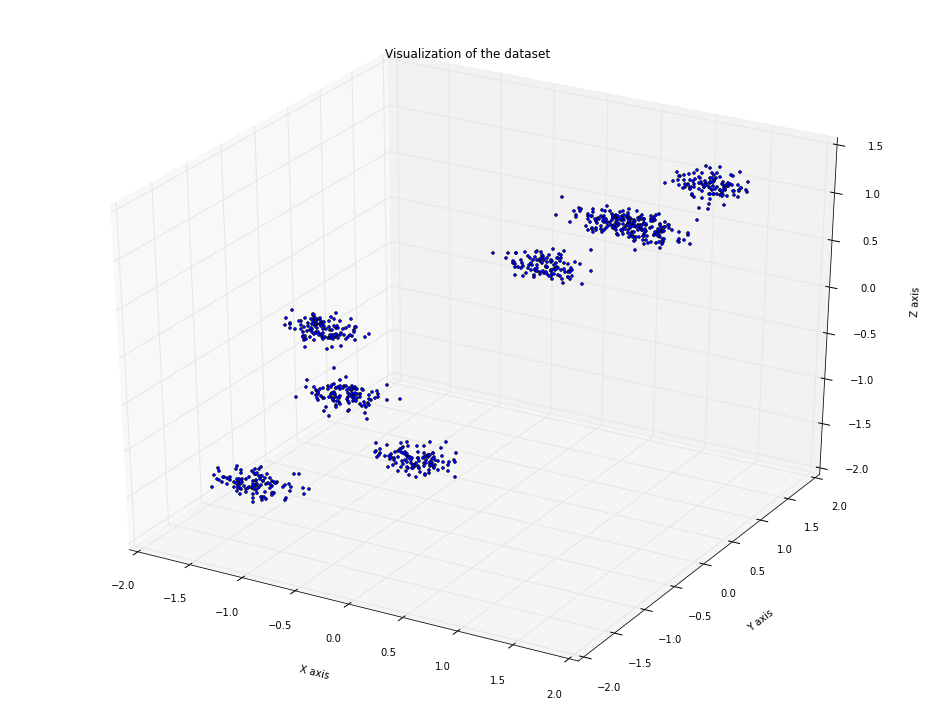

In [228]:
num = 900

centers = [[-2, -8, -6],[0, -4, -6], 
           [-2, -4, 2], [0, -8, 2], 
           [2, 2, 8], [2, -2, 8], 
           [4, 2, 12], [4, -2, 12]
          ]
dataArray, labs = make_blobs(n_samples=num, centers=centers, cluster_std=0.4, random_state=0)
dataArray = StandardScaler().fit_transform(dataArray)

# Plot the dataset

# figure,axis = pyplot.subplots(1,1)
# axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='g', markersize=5)
# axis.set_title('Visualization of the dataset')
# pyplot.show()

from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
fig.set_size_inches(16.5, 12.5)
axis = fig.add_subplot(111, projection='3d')
axis.set_title('Visualization of the dataset')
axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='b', markersize=3)
axis.set_xlabel('X axis')
axis.set_ylabel('Y axis')
axis.set_zlabel('Z axis')

In [229]:
dbscan_inbuilt, dbscan_labels = builtin_dbscan(dataArray)
print dbscan_labels.shape

numOfClusters: 8
noisePoints: 1
# of points with cluster ID 0 = 113
# of points with cluster ID 1 = 112
# of points with cluster ID 2 = 112
# of points with cluster ID 3 = 111
# of points with cluster ID 4 = 113
# of points with cluster ID 5 = 113
# of points with cluster ID 6 = 112
# of points with cluster ID 7 = 113
(900,)


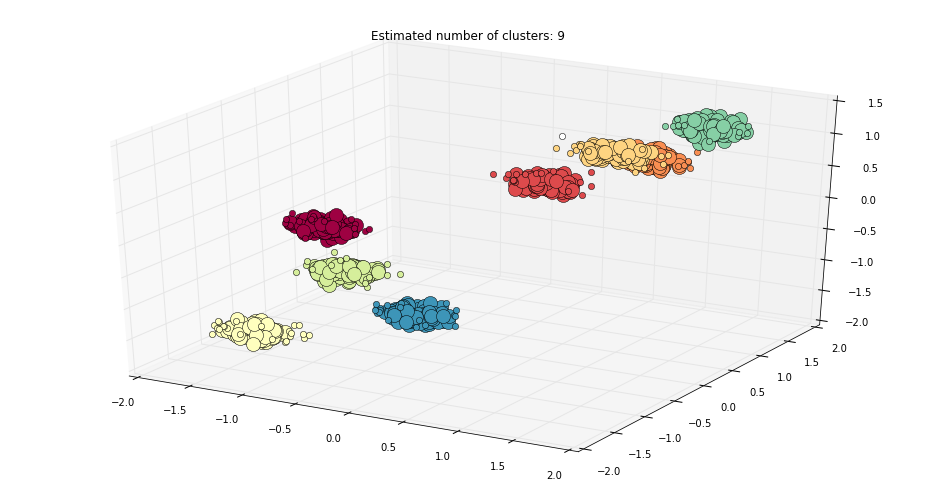

In [230]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
core_samples_mask[dbscan_inbuilt.core_sample_indices_] = True

unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

###
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
fig.set_size_inches(16.5, 8.5)
axis = fig.add_subplot(111, projection='3d')
# axis.set_title('Visualization of the dataset')
# axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='g', markersize=3)
####

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'w'

    class_member_mask = (dbscan_labels == k)

    xy = dataArray[class_member_mask & core_samples_mask]
    axis.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = dataArray[class_member_mask & ~core_samples_mask]
    axis.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

axis.set_title('Estimated number of clusters: %d' % len(unique_labels))
plt.show()

(900, 3)


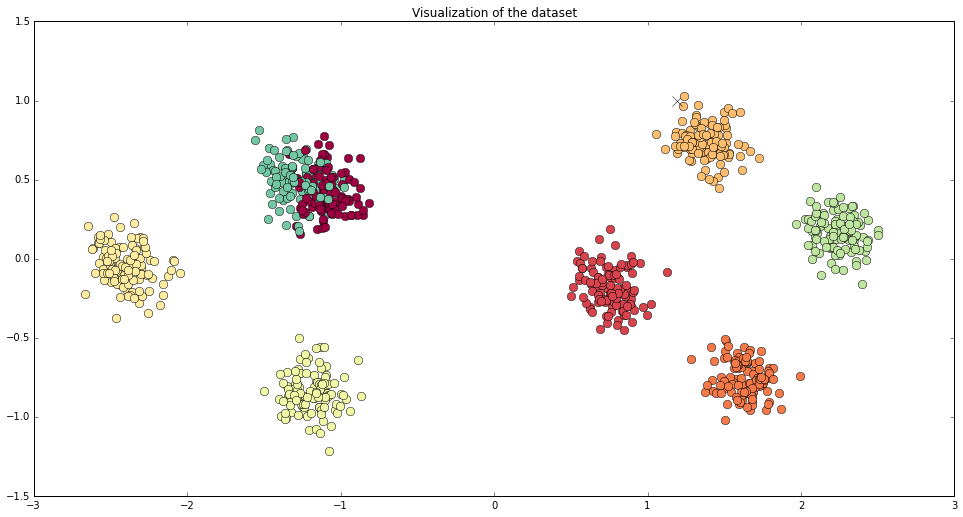

In [231]:
x = np.array(dataArray)
print x.shape
plot_pca(x, dbscan_labels)

## Load datasets

In [285]:
# Loads the data from the given file into a numpy array
def getDataSetFromFile(filePath, delimiter='\t', datatype=float):
    data_set = np.loadtxt(filePath, delimiter=delimiter, dtype=datatype)

    # Remove the first 2 columns
    # data_set = np.delete(data_set, (0,1), 1)
    
    # Add 2 columns at the end to keep track of visited points, and for labels
    zero_column = np.zeros((data_set.shape[0],1))
    data_set = np.concatenate((data_set, zero_column), axis=1)
    data_set = np.concatenate((data_set, zero_column), axis=1)
    
    # Shuffle the rows up
    # np.random.shuffle(data_set)
    
    return data_set


# Get the datasets
def loadDatasets():
    cho_dataset = getDataSetFromFile('dataset/cho.txt')
    iyer_dataset = getDataSetFromFile('dataset/iyer.txt')
    return cho_dataset, iyer_dataset


# Load datasets
print 'Loading datasets...'
cho_dataset, iyer_dataset = loadDatasets()
print 'Datasets loaded.'
print 'The cho dataset contains', cho_dataset.shape[0], 'record, with', cho_dataset.shape[1]-1, 'features'
print 'The iyer dataset contains', iyer_dataset.shape[0], 'record, with', iyer_dataset.shape[1]-1, 'features'
print '2 columns have been added at the end to keep track of visited points, and labels.'

Loading datasets...
Datasets loaded.
The cho dataset contains 386 record, with 19 features
The iyer dataset contains 517 record, with 15 features
2 columns have been added at the end to keep track of visited points, and labels.


## Demo: Density reachable points

#### Just a demo of density reachability. Given a point P, we have found all neighbors of P <br>that lie within an eps radius of it - also known as density reachable points of P.

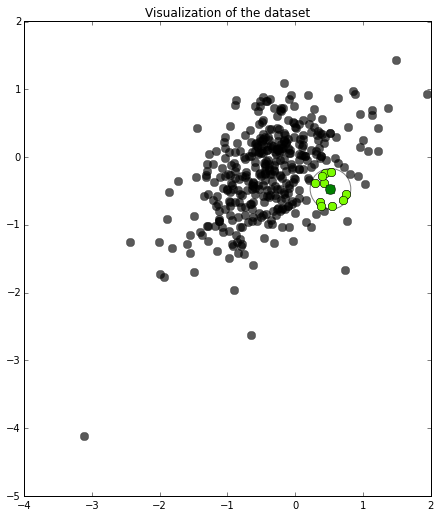

In [233]:
eps = 0.3
cho_dataset_subset = cho_dataset[:, 0:6]

current_point = cho_dataset_subset[354]
neighborhood = regionQuery(P=current_point, eps=eps, D=cho_dataset_subset)
circleCentres = []
circleCentres.append(current_point[2:4])
circleCentres = np.array(circleCentres)

plotPointsAndCircles(cho_dataset_subset[:, 2:4], circleCentres, neighborhood=neighborhood[:,2:4], radius=eps)

In [323]:
# Run DB scan
def run_dbscan(data_set, eps, min_pts):
    # print "\nStarting DB scan\n----------------"
    # start_time = time.time()
    clustering_result_map, noise_pts = dbscan(data_set, eps=eps, min_pts=min_pts)
    # print "DB scan completed in", (time.time() - start_time), "seconds."

    data_set, gene_map = convert_to_silhoutte_format(data_set, clustering_result_map)
    
    # Evaluate
    jaccard, rand, silhouette = evaluate(data_set, clustering_result_map, gene_map)
    
    return clustering_result_map, noise_pts, jaccard, rand, silhouette, data_set[:,-1]


# Run DBscan with varying hyper parameter values
# EPS goes from 1 to 5 in increments of 0.1
# Min pts goes from 1 to 30 in increments of 1
def run_dbscan_on_range(dataset_name, data_set, eps_range = np.arange(1.0, 5.0, 0.1), min_pts_range = np.arange(1, 30, 1)):
    
    # The results matrix will have 7 columns (eps, min_pts, numOfClusters, numOfNoisePts, jaccard, rand, silhouette)
    results = np.empty(((eps_range.shape[0]*min_pts_range.shape[0]),7))
    label_results = []

    print '\n-----\n',dataset_name,'\n-----\neps\tmin_pts\t\tclusters\tnoise\tjaccard\trand\tsilhouette'
    count = 0
    data_set_original = np.array(data_set)
    for eps in eps_range:
        for min_pts in min_pts_range:
            data_set = np.array(data_set_original)
            clust_result_map, noise_pts, jaccard, rand, silhouette, labels = run_dbscan(data_set, eps, min_pts)
            print eps,'\t',min_pts,'\t\t',len(clust_result_map),'\t\t',len(noise_pts),'\t',"{0:.4f}".format(jaccard),'\t',"{0:.4f}".format(rand),'\t',"{0:.4f}".format(silhouette)
            new_row = [eps, min_pts, len(clust_result_map), len(noise_pts), jaccard, rand, silhouette]
            results[count] = new_row
            label_results.append(labels) 
            count += 1
            
    return results, label_results


# Run for CHO
final_results_cho, label_results_cho = run_dbscan_on_range("cho", cho_dataset, np.arange(1.9, 2.0, 0.3), np.arange(1, 10, 4))

# Run for IYER
final_results_iyer, label_results_iyer = run_dbscan_on_range("iyer", iyer_dataset, np.arange(1.9, 2.0, 0.3), np.arange(1, 10, 4))


-----
cho 
-----
eps	min_pts		clusters	noise	jaccard	rand	silhouette
1.9 	1 		14 		0 	0.2249 	0.2635 	0.0553
1.9 	5 		1 		13 	0.2248 	0.2635 	1.0000
1.9 	9 		1 		13 	0.2248 	0.2635 	1.0000

-----
iyer 
-----
eps	min_pts		clusters	noise	jaccard	rand	silhouette
1.9 	1 		49 		0 	0.1493 	0.3086 	0.1882
1.9 	5 		1 		59 	0.1527 	0.3289 	1.0000
1.9 	9 		1 		85 	0.1650 	0.4076 	1.0000



For dataset ==> cho
Highest jaccard co-efficient value = 0.224939255241  for eps = 1.9 and min_pts = 1.0


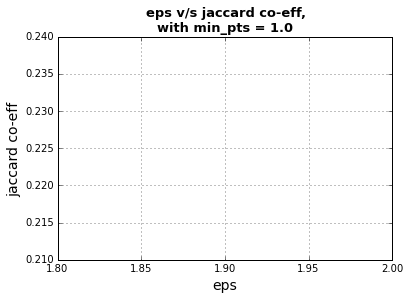

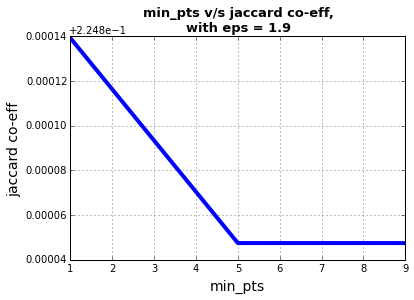


For dataset ==> iyer
Highest jaccard co-efficient value = 0.16498874058  for eps = 1.9 and min_pts = 9.0


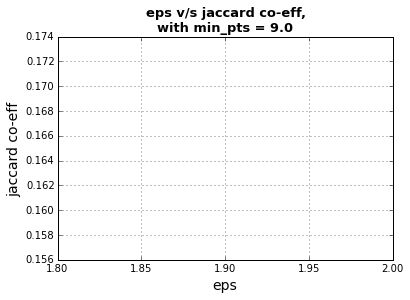

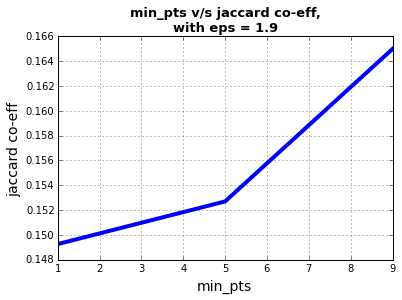

In [324]:
def plot_jaccard(clust_results, dataset_name):
    
    # Find max eps and min_pts
    row_id_with_max_jaccard = np.argmax(clust_results[:,-3])
    eps_max = clust_results[row_id_with_max_jaccard, 0]
    min_pts_max = clust_results[row_id_with_max_jaccard, 1]
    
    print '\nFor dataset ==>', dataset_name
    print 'Highest jaccard co-efficient value =', np.amax(clust_results[:,-3]), ' for eps =', eps_max, 'and min_pts =', min_pts_max
    
    rows_with_max_eps = clust_results[clust_results[:,0]==eps_max]
    rows_with_max_minpts = clust_results[clust_results[:,1]==min_pts_max]
    
    plt.title('eps v/s jaccard co-eff, \nwith min_pts = ' + str(min_pts_max), fontsize=13, fontweight='semibold')
    plt.xlabel('eps', fontsize=14)
    plt.ylabel('jaccard co-eff', fontsize=14)
    plt.plot(rows_with_max_minpts[:,0], rows_with_max_minpts[:,-3], linewidth=4, c='g')
    plt.grid(True)
    plt.show()
    
    plt.title('min_pts v/s jaccard co-eff, \nwith eps = ' + str(eps_max), fontsize=13, fontweight='semibold')
    plt.xlabel('min_pts', fontsize=14)
    plt.ylabel('jaccard co-eff', fontsize=14)
    plt.plot(rows_with_max_eps[:,1], rows_with_max_eps[:,-3], linewidth=4, c='b')
    plt.grid(True)
    plt.show()
    
plot_jaccard(final_results_cho, "cho")
plot_jaccard(final_results_iyer, "iyer")


For dataset ==> cho
Highest rand co-efficient value = 0.263537276168  for eps = 1.9 and min_pts = 1.0


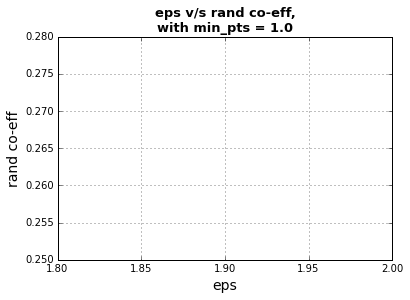

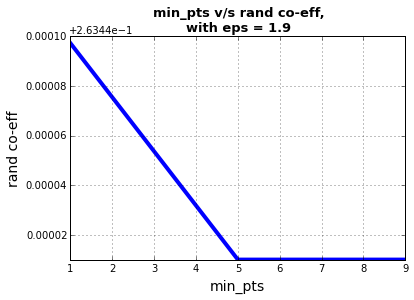


For dataset ==> iyer
Highest rand co-efficient value = 0.407629943619  for eps = 1.9 and min_pts = 9.0


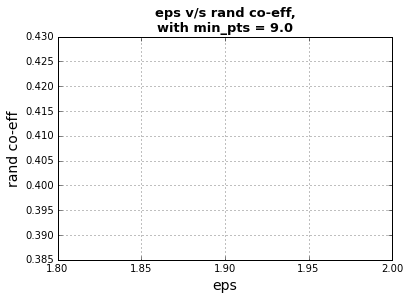

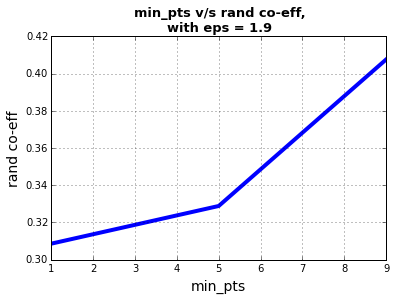

In [325]:
def plot_rand(clust_results, dataset_name):
    
    # Find max eps and min_pts
    row_id_with_max_rand = np.argmax(clust_results[:,-2])
    eps_max = clust_results[row_id_with_max_rand, 0]
    min_pts_max = clust_results[row_id_with_max_rand, 1]
    
    print '\nFor dataset ==>', dataset_name
    print 'Highest rand co-efficient value =', np.amax(clust_results[:,-2]), ' for eps =', eps_max, 'and min_pts =', min_pts_max
    
    rows_with_max_eps = clust_results[clust_results[:,0]==eps_max]
    rows_with_max_minpts = clust_results[clust_results[:,1]==min_pts_max]
    
    plt.title('eps v/s rand co-eff, \nwith min_pts = ' + str(min_pts_max), fontsize=13, fontweight='semibold')
    plt.xlabel('eps', fontsize=14)
    plt.ylabel('rand co-eff', fontsize=14)
    plt.plot(rows_with_max_minpts[:,0], rows_with_max_minpts[:,-2], linewidth=4, c='g')
    plt.grid(True)
    plt.show()
    
    plt.title('min_pts v/s rand co-eff, \nwith eps = ' + str(eps_max), fontsize=13, fontweight='semibold')
    plt.xlabel('min_pts', fontsize=14)
    plt.ylabel('rand co-eff', fontsize=14)
    plt.plot(rows_with_max_eps[:,1], rows_with_max_eps[:,-2], linewidth=4, c='b')
    plt.grid(True)
    plt.show()
    
plot_rand(final_results_cho, "cho")
plot_rand(final_results_iyer, "iyer")


For dataset ==> cho
Highest silhouette value = 0.999999996979  for eps = 1.9 and min_pts = 5.0


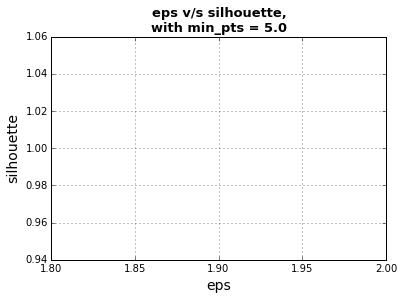

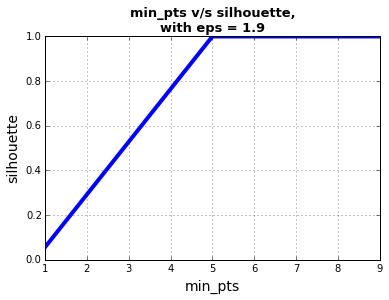


For dataset ==> iyer
Highest silhouette value = 0.999999997508  for eps = 1.9 and min_pts = 9.0


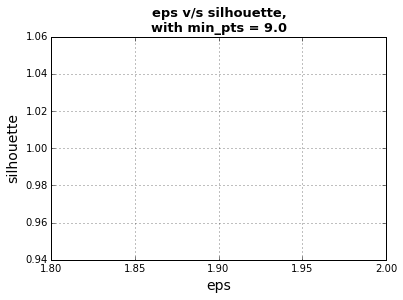

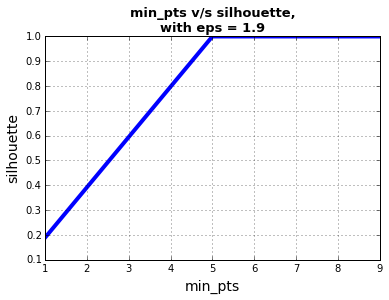

In [326]:
def plot_silhouette(clust_results, dataset_name):
    
    # Find max eps and min_pts
    row_id_with_max_silhouette = np.argmax(clust_results[:,-1])
    eps_max = clust_results[row_id_with_max_silhouette, 0]
    min_pts_max = clust_results[row_id_with_max_silhouette, 1]
    
    print '\nFor dataset ==>', dataset_name
    print 'Highest silhouette value =', np.amax(clust_results[:,-1]), ' for eps =', eps_max, 'and min_pts =', min_pts_max
    
    rows_with_max_eps = clust_results[clust_results[:,0]==eps_max]
    rows_with_max_minpts = clust_results[clust_results[:,1]==min_pts_max]
    
    plt.title('eps v/s silhouette, \nwith min_pts = ' + str(min_pts_max), fontsize=13, fontweight='semibold')
    plt.xlabel('eps', fontsize=14)
    plt.ylabel('silhouette', fontsize=14)
    plt.plot(rows_with_max_minpts[:,0], rows_with_max_minpts[:,-1], linewidth=4, c='g')
    plt.grid(True)
    plt.show()
    
    plt.title('min_pts v/s silhouette, \nwith eps = ' + str(eps_max), fontsize=13, fontweight='semibold')
    plt.xlabel('min_pts', fontsize=14)
    plt.ylabel('silhouette', fontsize=14)
    plt.plot(rows_with_max_eps[:,1], rows_with_max_eps[:,-1], linewidth=4, c='b')
    plt.grid(True)
    plt.show()
    
plot_silhouette(final_results_cho, "cho")
plot_silhouette(final_results_iyer, "iyer")

## Comparison with inbuilt DB-scan function from the scikit library

In [327]:
# Calling built-in DB-scan
builtin_results = builtin_dbscan(iyer_dataset[:, 2:iyer_dataset.shape[1]-2], eps=1.0, minPts = 5)

numOfClusters: 3
noisePoints: 174
# of points with cluster ID 0 = 311
# of points with cluster ID 1 = 5
# of points with cluster ID 2 = 27


## Visualization of clustering results

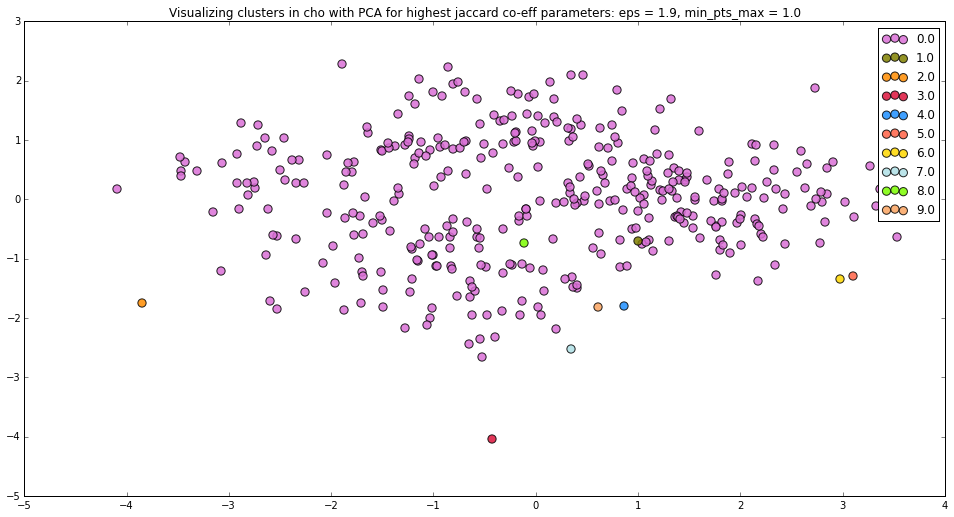

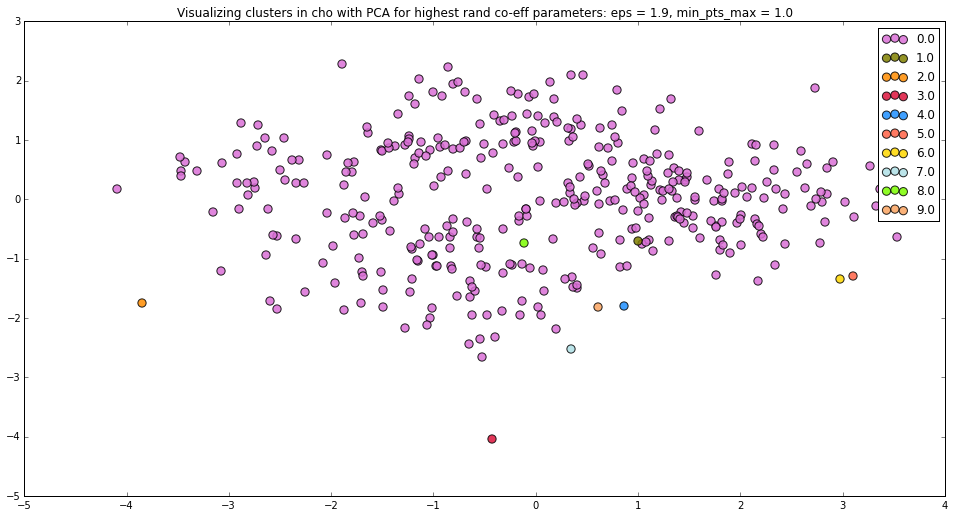

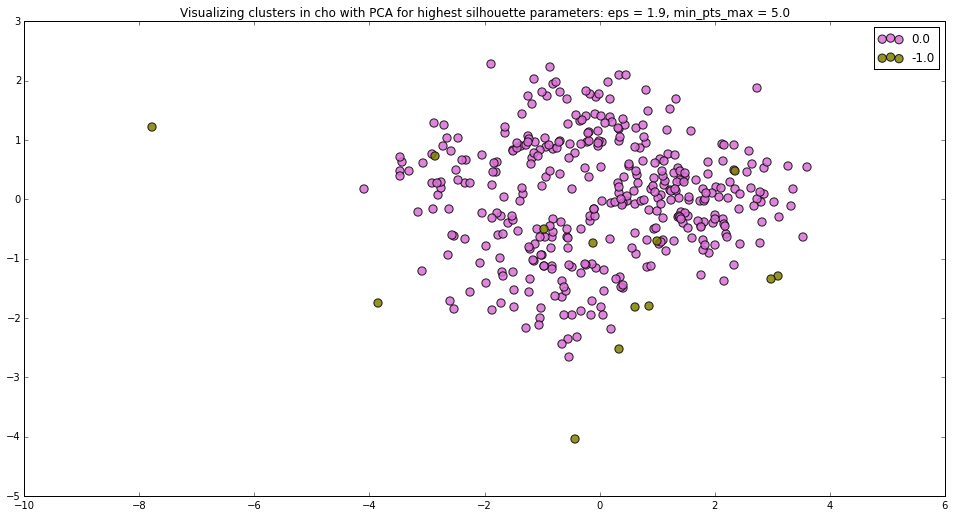

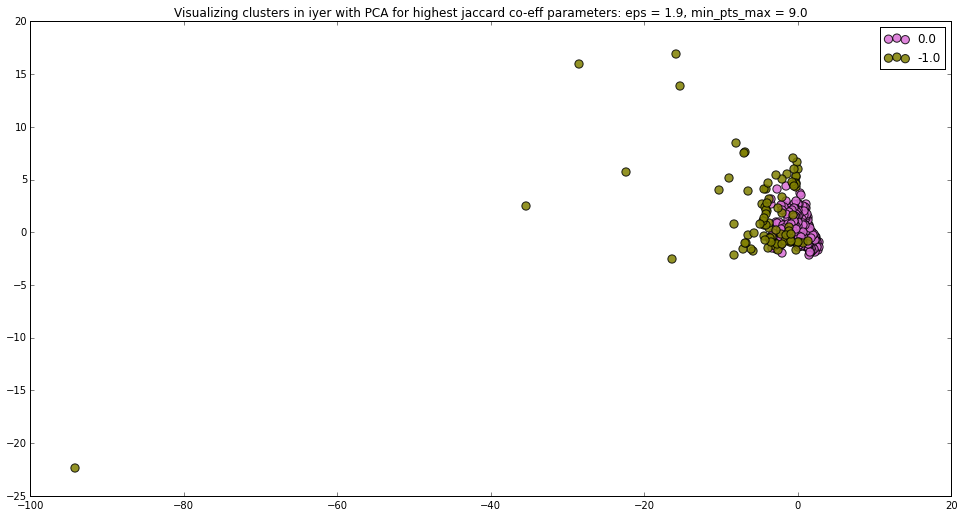

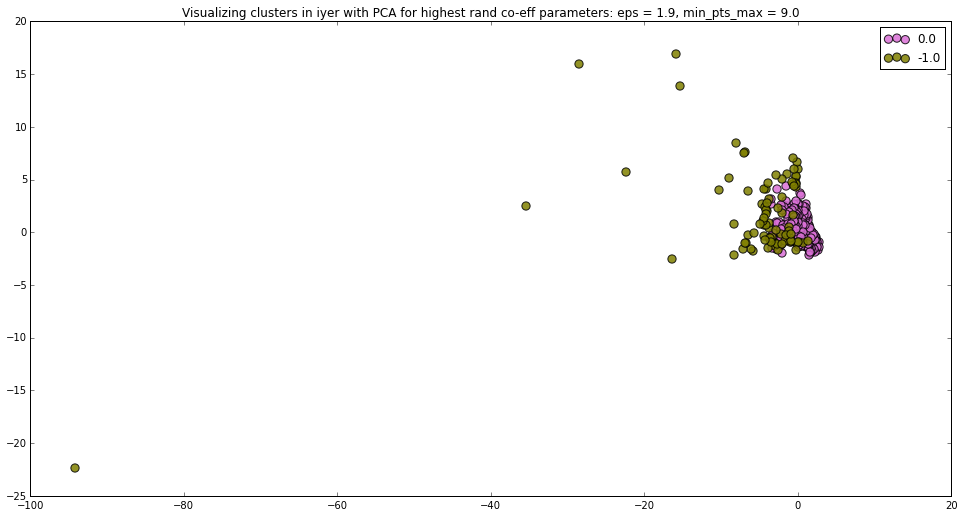

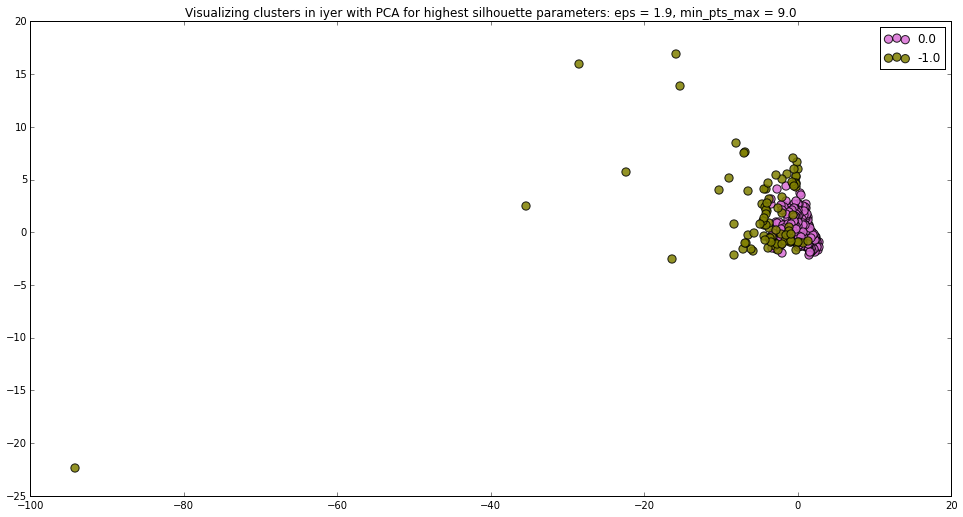

In [329]:
def visualize_final_clusters(dataset_name, dataset, clus_results, label_results):

    row_id_with_max_jaccard = np.argmax(clus_results[:,-3])
    eps_max = clus_results[row_id_with_max_jaccard, 0]
    min_pts_max = clus_results[row_id_with_max_jaccard, 1]
    label_set=label_results[row_id_with_max_jaccard]
    title='Visualizing clusters in ' + dataset_name + ' with PCA for highest jaccard co-eff parameters: eps = ' + str(eps_max) + ', min_pts_max = ' + str(min_pts_max)
    doPCA(dataset, label_set, title)
    
    row_id_with_max_rand = np.argmax(clus_results[:,-2])
    eps_max = clus_results[row_id_with_max_rand, 0]
    min_pts_max = clus_results[row_id_with_max_rand, 1]
    label_set=label_results[row_id_with_max_rand]
    title='Visualizing clusters in ' + dataset_name + ' with PCA for highest rand co-eff parameters: eps = ' + str(eps_max) + ', min_pts_max = ' + str(min_pts_max)
    doPCA(dataset, label_set, title)

    row_id_with_max_silhouette = np.argmax(clus_results[:,-1])
    eps_max = clus_results[row_id_with_max_silhouette, 0]
    min_pts_max = clus_results[row_id_with_max_silhouette, 1]
    label_set=label_results[row_id_with_max_silhouette]
    title='Visualizing clusters in ' + dataset_name + ' with PCA for highest silhouette parameters: eps = ' + str(eps_max) + ', min_pts_max = ' + str(min_pts_max)
    doPCA(dataset, label_set, title)

visualize_final_clusters("cho", cho_dataset[:, 2:-2], final_results_cho, label_results_cho)
visualize_final_clusters("iyer", iyer_dataset[:, 2:-2], final_results_iyer, label_results_iyer)